In [1]:
# !pip uninstall gym

In [2]:
# !pip install gym==0.25.0

In [3]:
# please install gym with version of 0.25. 

# Import Dependencies

In [4]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import numpy as np
from collections import deque
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

# Compatibility Check for NumPy 'bool8'
Belows checks if np.bool8 exists in the current NumPy version. If not, it sets np.bool8 to np.bool_.
Why: Some code or libraries might reference np.bool8 for boolean types. This ensures compatibility across different versions of NumPy.

In [5]:
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

## Loading CartPole Environment

In [6]:
env = gym.make("CartPole-v1")
print(env.action_space)
print(env.observation_space)

# Inside Box([min], [max])
# min[cart_position, cart_velovity, pole_angle, angular_velocity]
# max[cart_position, cart_velovity, pole_angle, angular_velocity]

Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


## Initial Observation

In [7]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.0444845   0.04168475 -0.0425585   0.01530446]


In [10]:
observation, reward, done, info = env.step(0)
def printInfo(observation, reward, done):
    print("New observations after choosing action 0:", observation)
    print("Reward for this step:", reward)
    print("Is this round done?", done)

## Task 1: Development of Q-Learning Based RL Agent

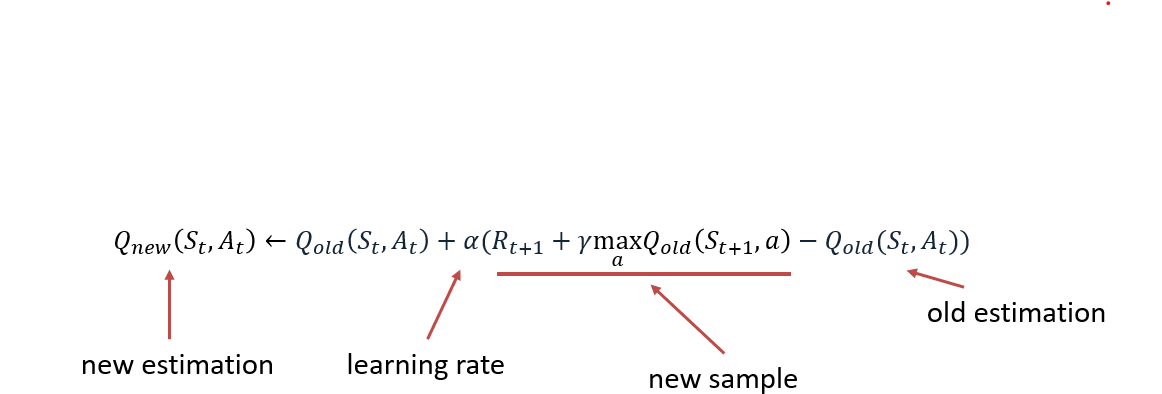

# Training Q Learning Based RL Agent

## Transforming a Continuous State Space:

Q-learning inherently works on **discrete states**; discretizing converts continuous values (like position, velocity, etc.) into finite, manageable bins. Hence, it simplifies the environment into a structured grid, allowing a Q-table to be used for storing and updating value estimates.

## Adjusting Observation Bounds

The raw observation bounds provided by the environment can be too wide or even unbounded for effective discretization. Therefore, we clipped the value (for **cart velocity** and pole **angular velocity**) to ensures that the discretized states are focused on realistic and useful ranges, improving learning stability.

Also, **Q-learning works best with controlled, bounded data** where the state space is well-defined, as this helps the Q-values converge reliably without being skewed by extreme, unmanageable values.

# Epsilon-Greedy Action Selection:

This balances **exploration** (random action choices) with **exploitation** (choosing the best-known action) to prevent the agent from getting stuck in suboptimal strategies.

## Decaying Epsilon
As the exploration rate (epsilon) decays, the aget gradually shifts towards exploiting its learned knowledge, leading to more consistent performance.

## Q-Learning Update and Performance Monitoring
The Q-learning update rule adjusts the Q-values based on both the immediate reward and the estimated future rewards. This iterative mechanism enables the agent to gradually learn the value of each state-action pair, which in turn improves its decision-making process over time. Simultaneously, tracking recent rewards using a deque provides a clear measure of the agent's performance. By continuously monitoring the average reward, we can determine when the agent has effectively mastered the task—typically when the average reward exceeds a specified threshold, indicating successful learning and convergence.

In [9]:
# Define discretization parameters:
# (number of bins for cart position, cart velocity, pole angle, pole angular velocity)
num_bins = (10, 10, 30, 30)

def create_bins(num_bins, lower_bounds, upper_bounds):
    bins = []
    for i in range(len(num_bins)):
        # Create num_bins[i]-1 cut points between lower and upper bound
        bins.append(np.linspace(lower_bounds[i], upper_bounds[i], num_bins[i] - 1))
    return bins

def discretize_state(state, bins):
    # Map each continuous state value into its corresponding bin index
    return tuple(np.digitize(s, b) for s, b in zip(state, bins))

# Get observation space bounds and adjust unbounded values
obs_space = env.observation_space
lower_bounds = obs_space.low.copy()
upper_bounds = obs_space.high.copy()

# Clip cart velocity and pole angular velocity to a reasonable range
lower_bounds[1] = -5
upper_bounds[1] = 5
lower_bounds[3] = -5
upper_bounds[3] = 5

# Create bins for discretization
bins = create_bins(num_bins, lower_bounds, upper_bounds)

# Initialize the Q-table.
# The shape is (bins for cart position, bins for cart velocity, bins for pole angle, bins for pole angular velocity, number of actions)
q_table_shape = num_bins + (env.action_space.n,)
Q = np.zeros(q_table_shape)

# Q-learning hyperparameters
alpha = 0.1      # Learning rate
gamma = 0.99     # Discount factor
epsilon = 0.85    # Starting exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995
max_steps = 500

# For tracking recent rewards (last 100 episodes)
rewards_deque = deque(maxlen=100)

episode = 0
while True:
    episode += 1
    state = env.reset()
    state_disc = discretize_state(state, bins)
    cumulative_reward = 0
    done = False

    for step in range(max_steps):        
        # ε-greedy action selection:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Exploration
        else:
            action = np.argmax(Q[state_disc])    # Exploitation: choose best action
        
        next_state, reward, done, info = env.step(action)
        cumulative_reward += reward
        
        # Discretize the next state
        next_state_disc = discretize_state(next_state, bins)
        
        # Q-learning update rule:
        best_next_q = np.max(Q[next_state_disc])
        Q[state_disc + (action,)] += alpha * (reward + gamma * best_next_q - Q[state_disc + (action,)])
        
        state_disc = next_state_disc
        state = next_state
        
        if done:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_deque.append(cumulative_reward)
    
    if episode % 1000 == 0:
        avg_reward = np.mean(rewards_deque)
        print(f"Episode {episode}: Reward = {cumulative_reward}, Average (last 100) = {avg_reward:.2f}")
    
    if len(rewards_deque) == 100 and np.mean(rewards_deque) >= 500:
        print(f"Solved in episode {episode} with an average reward of {np.mean(rewards_deque):.2f}!")
        break

env.close()

Episode 1000: Reward = 82.0, Average (last 100) = 34.85
Episode 2000: Reward = 31.0, Average (last 100) = 47.11
Episode 3000: Reward = 29.0, Average (last 100) = 52.50
Episode 4000: Reward = 37.0, Average (last 100) = 110.43
Episode 5000: Reward = 210.0, Average (last 100) = 122.92
Episode 6000: Reward = 467.0, Average (last 100) = 229.34
Episode 7000: Reward = 355.0, Average (last 100) = 234.69
Episode 8000: Reward = 500.0, Average (last 100) = 436.52
Episode 9000: Reward = 500.0, Average (last 100) = 488.78
Episode 10000: Reward = 500.0, Average (last 100) = 403.71
Episode 11000: Reward = 500.0, Average (last 100) = 470.14
Episode 12000: Reward = 500.0, Average (last 100) = 414.61
Episode 13000: Reward = 500.0, Average (last 100) = 460.05
Episode 14000: Reward = 500.0, Average (last 100) = 473.75
Episode 15000: Reward = 500.0, Average (last 100) = 473.74
Episode 16000: Reward = 500.0, Average (last 100) = 461.77
Episode 17000: Reward = 500.0, Average (last 100) = 461.79
Episode 18000

# Save the bins and Q-Table for evaluation

Saving the Q-table and discretization bins allows you to preserve the learned model for later evaluation or deployment without retraining.

In [11]:
np.save("q_learning_q_table.npy", Q)
np.save("q_learning_bins.npy", np.array(bins, dtype=object), allow_pickle=True)

# Evaluation Phase in Q-Learning Evaluation (In Evaluation file)